# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.


## Task 1: Dependencies and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [27]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121 langchain_huggingface==0.2.0

zsh:1: command not found: pip


We'll need an HF Token:

In [6]:
import os
import getpass

os.environ["HF_TOKEN"] = getpass.getpass("HF Token Key:")

And the LangSmith set-up:

In [7]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Session 16 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

Let's verify our project so we can leverage it in LangSmith later.

In [3]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Session 16 - 79b0ed43


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

In [7]:
from google.colab import files
uploaded = files.upload()

Saving eu_ai_act.html to eu_ai_act (1).html


In [8]:
file_path = "./DeepSeek_R1.pdf"
file_path

'./DeepSeek_R1.pdf'

We'll define our chunking strategy.

In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [10]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [11]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings
import hashlib

YOUR_EMBED_MODEL_URL = "https://b8pzmfqdpu4pwkdv.us-east-1.aws.endpoints.huggingface.cloud"

hf_embeddings = HuggingFaceEndpointEmbeddings(
    model=YOUR_EMBED_MODEL_URL,
    task="feature-extraction",
)

collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=768, distance=Distance.COSINE),
)

# Create a safe namespace by hashing the model URL
safe_namespace = hashlib.md5(hf_embeddings.model.encode()).hexdigest()

store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    hf_embeddings, store, namespace=safe_namespace, batch_size=32
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 1})

/Users/akshayvernekar/code/Session5/AIE5/16_LLMOps/.venv/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

##### Answer #1:


### When to Use Cache-Backed Embeddings

### Most Useful Situations

#### **Embedding Generation is the Performance Bottleneck**
- When embedding computation consumes significant resources (GPU/CPU time)
- For applications with strict latency requirements where milliseconds matter  
  **Example:** A real-time customer service application that needs immediate responses

#### **High Text Redundancy Patterns**
- Applications that repeatedly process the same documents or text fragments
- Systems that handle common user queries or FAQs  
  **Example:** A product search engine where users frequently search for similar items

#### **Large-Scale Batch Processing**
- ETL pipelines processing millions of documents where many contain similar sections
- Data migration projects where identical content appears across multiple sources  
  **Example:** An enterprise document management system indexing company reports with boilerplate sections

#### **Limited Embedding Model Access**
- When using API-based embedding services with rate limits or usage-based pricing
- Environments with intermittent connectivity to cloud-based embedding services  
  **Example:** A mobile application that needs to function with limited internet connectivity


### Least Useful Situations

#### **Predominantly Unique Text Content**
- Applications where almost every input is unique with minimal repetition
- Systems processing highly specific user-generated content  
  **Example:** A personal journal app where each entry is unique and personal

#### **Rapidly Evolving Data**
- When cached embeddings quickly become outdated due to changing source material
- Systems where semantic drift occurs (meaning of terms changes over time)  
  **Example:** News analysis platforms where context and relevance shift hourly

#### **Memory/Storage Constraints**
- Edge devices with limited storage capacity
- Applications where the overhead of cache management exceeds benefits  
  **Example:** IoT devices with minimal RAM and storage capabilities

#### **Cold Start Scenarios**
- New applications without an established cache of common embeddings
- One-off analysis projects that don't benefit from persistence  
  **Example:** A one-time data analysis project with no future similar workloads


## Implementation Considerations

### **Cache Eviction Strategies**
- LRU (Least Recently Used) vs. LFU (Least Frequently Used) policies
- Time-based expiration for domains with temporal relevance  
  **Example:** Setting shorter cache lifetimes for news content vs. reference materials

### **Cache Warming**
- Pre-computing embeddings for common queries during off-peak hours
- Strategically seeding the cache with high-value content  
  **Example:** Processing trending topics before they generate high traffic

### **Hybrid Approaches**
- Combining caching with on-the-fly embedding generation
- Fallback mechanisms when cache misses occur  
  **Example:** Caching embeddings for common product categories while computing real-time embeddings for unique customer queries

### **Monitoring and Analytics**
- Tracking cache hit/miss ratios to optimize caching strategy
- Measuring performance improvements and resource savings  
  **Example:** Dashboards showing embedding computation time saved through caching







##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [12]:
### YOUR CODE HERE

import time

def measure_retriever_performance(vectorstore, docs, search_type="mmr", k=3):
    start_time = time.perf_counter()
    vectorstore.add_documents(docs)
    retriever = vectorstore.as_retriever(search_type=search_type, search_kwargs={"k": k})
    end_time = time.perf_counter()
    duration = end_time - start_time
    
    print(f"Duration: {duration:.4f} seconds")
    return retriever, duration

retriever, duration = measure_retriever_performance(vectorstore, docs)




Duration: 0.0328 seconds


In [13]:
import time
def test_cache_backed_embeddings(texts):
	start_time = time.time()
	#Call out to HuggingFaceHub’s embedding endpoint for embedding texts.
	embeddings_no_cache = hf_embeddings.embed_documents(texts)
	time_no_cache = time.time() - start_time

	start_time = time.time()
	#The method first checks the cache for the embeddings. 
	#If the embeddings are not found, the method uses the underlying embedder to embed the documents and stores the results in the cache.
	embeddings_with_cache_1 = cached_embedder.embed_documents(texts)
	time_with_cache_1 = time.time() - start_time

	start_time = time.time()
	#2nd run . At this time the embeddings of texts should already be in memory
	embeddings_with_cache_2 = cached_embedder.embed_documents(texts)
	time_with_cache_2 = time.time() - start_time

	print(f"Time without cache: {time_no_cache:.4f} seconds")
	print(f"Time with cache, 1st run: {time_with_cache_1:.4f} seconds")
	print(f"Time with cache, 2nd run: {time_with_cache_2:.4f} seconds")
	print(f"Embeddings are the same:", embeddings_with_cache_1 == embeddings_with_cache_2)
	
test_cache_backed_embeddings("Deepseek-R1 screwing our stocks")


Time without cache: 0.1129 seconds
Time with cache, 1st run: 0.1235 seconds
Time with cache, 2nd run: 0.0040 seconds
Embeddings are the same: True


### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [14]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [30]:
from langchain_core.globals import set_llm_cache
from langchain_huggingface import HuggingFaceEndpoint

YOUR_LLM_ENDPOINT_URL = "https://ixkdmsdfs2vxegu8.us-east-1.aws.endpoints.huggingface.cloud"

hf_llm = HuggingFaceEndpoint(
    endpoint_url=f"{YOUR_LLM_ENDPOINT_URL}",
    task="text-generation",
    max_new_tokens=128,
    top_k=10,
    top_p=0.95,
    typical_p=0.95,
    temperature=0.01,
    repetition_penalty=1.03,
)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Setting up the cache can be done as follows:

In [31]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!


### Limitations & Use Cases of Caching

#### Limitations:
- Requires a substantial number of cached examples to be effective.
- Needs sufficient memory or storage capacity to maintain the cache.
- Best suited for static or rarely changing information (e.g., not ideal for dynamic data like stock prices or breaking news).
- Cached data must stay consistent with the original source to remain accurate.
- Some models or systems impose context limits, restricting cache effectiveness.
- Exact prompt matching is often required to retrieve cached results, limiting flexibility.

#### When Caching is Most Useful:
- When repeatedly processing the same queries or data.
- When working with large datasets that benefit from quick retrieval.
- When minimizing latency and improving response times is a priority.
- When computational efficiency and cost reduction are important.

#### When Caching is Least Useful:
- When information is highly dynamic and changes frequently.
- When query variations are significant, reducing cache hit rates.
- When applications require large or complex context windows that caching cannot efficiently handle.

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [ ]:
### YOUR CODE HERE

# Here is code snippet for testing the cache-backed llm with RAG LCEL chain with cache and without cache
#start_time = time.perf_counter()
#retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})
#end_time = time.perf_counter()
#duration = end_time - start_time
#print(f"Duration: {duration} seconds")



## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [32]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | hf_llm
    )

Let's test it out!

In [34]:
# Here is code snippet for testing the RAG LCEL chain without cache
start_time = time.perf_counter()
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})
end_time = time.perf_counter()
duration = end_time - start_time
print(f"Duration: {duration} seconds")

/Users/akshayvernekar/code/Session5/AIE5/16_LLMOps/.venv/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)
/Users/akshayvernekar/code/Session5/AIE5/16_LLMOps/.venv/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please

Duration: 6.522485583000162 seconds


In [35]:
# Here is code snippet for testing the RAG LCEL chain with cache 
start_time = time.perf_counter()
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})
end_time = time.perf_counter()
duration = end_time - start_time
print(f"Duration: {duration} seconds")

Duration: 0.16887379199988573 seconds


/Users/akshayvernekar/code/Session5/AIE5/16_LLMOps/.venv/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


In [36]:
# Final Run with cache
start_time = time.perf_counter()
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})
end_time = time.perf_counter()
duration = end_time - start_time
print(f"Duration: {duration} seconds")

Duration: 0.11906637499987482 seconds


/Users/akshayvernekar/code/Session5/AIE5/16_LLMOps/.venv/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

### Trace without cache

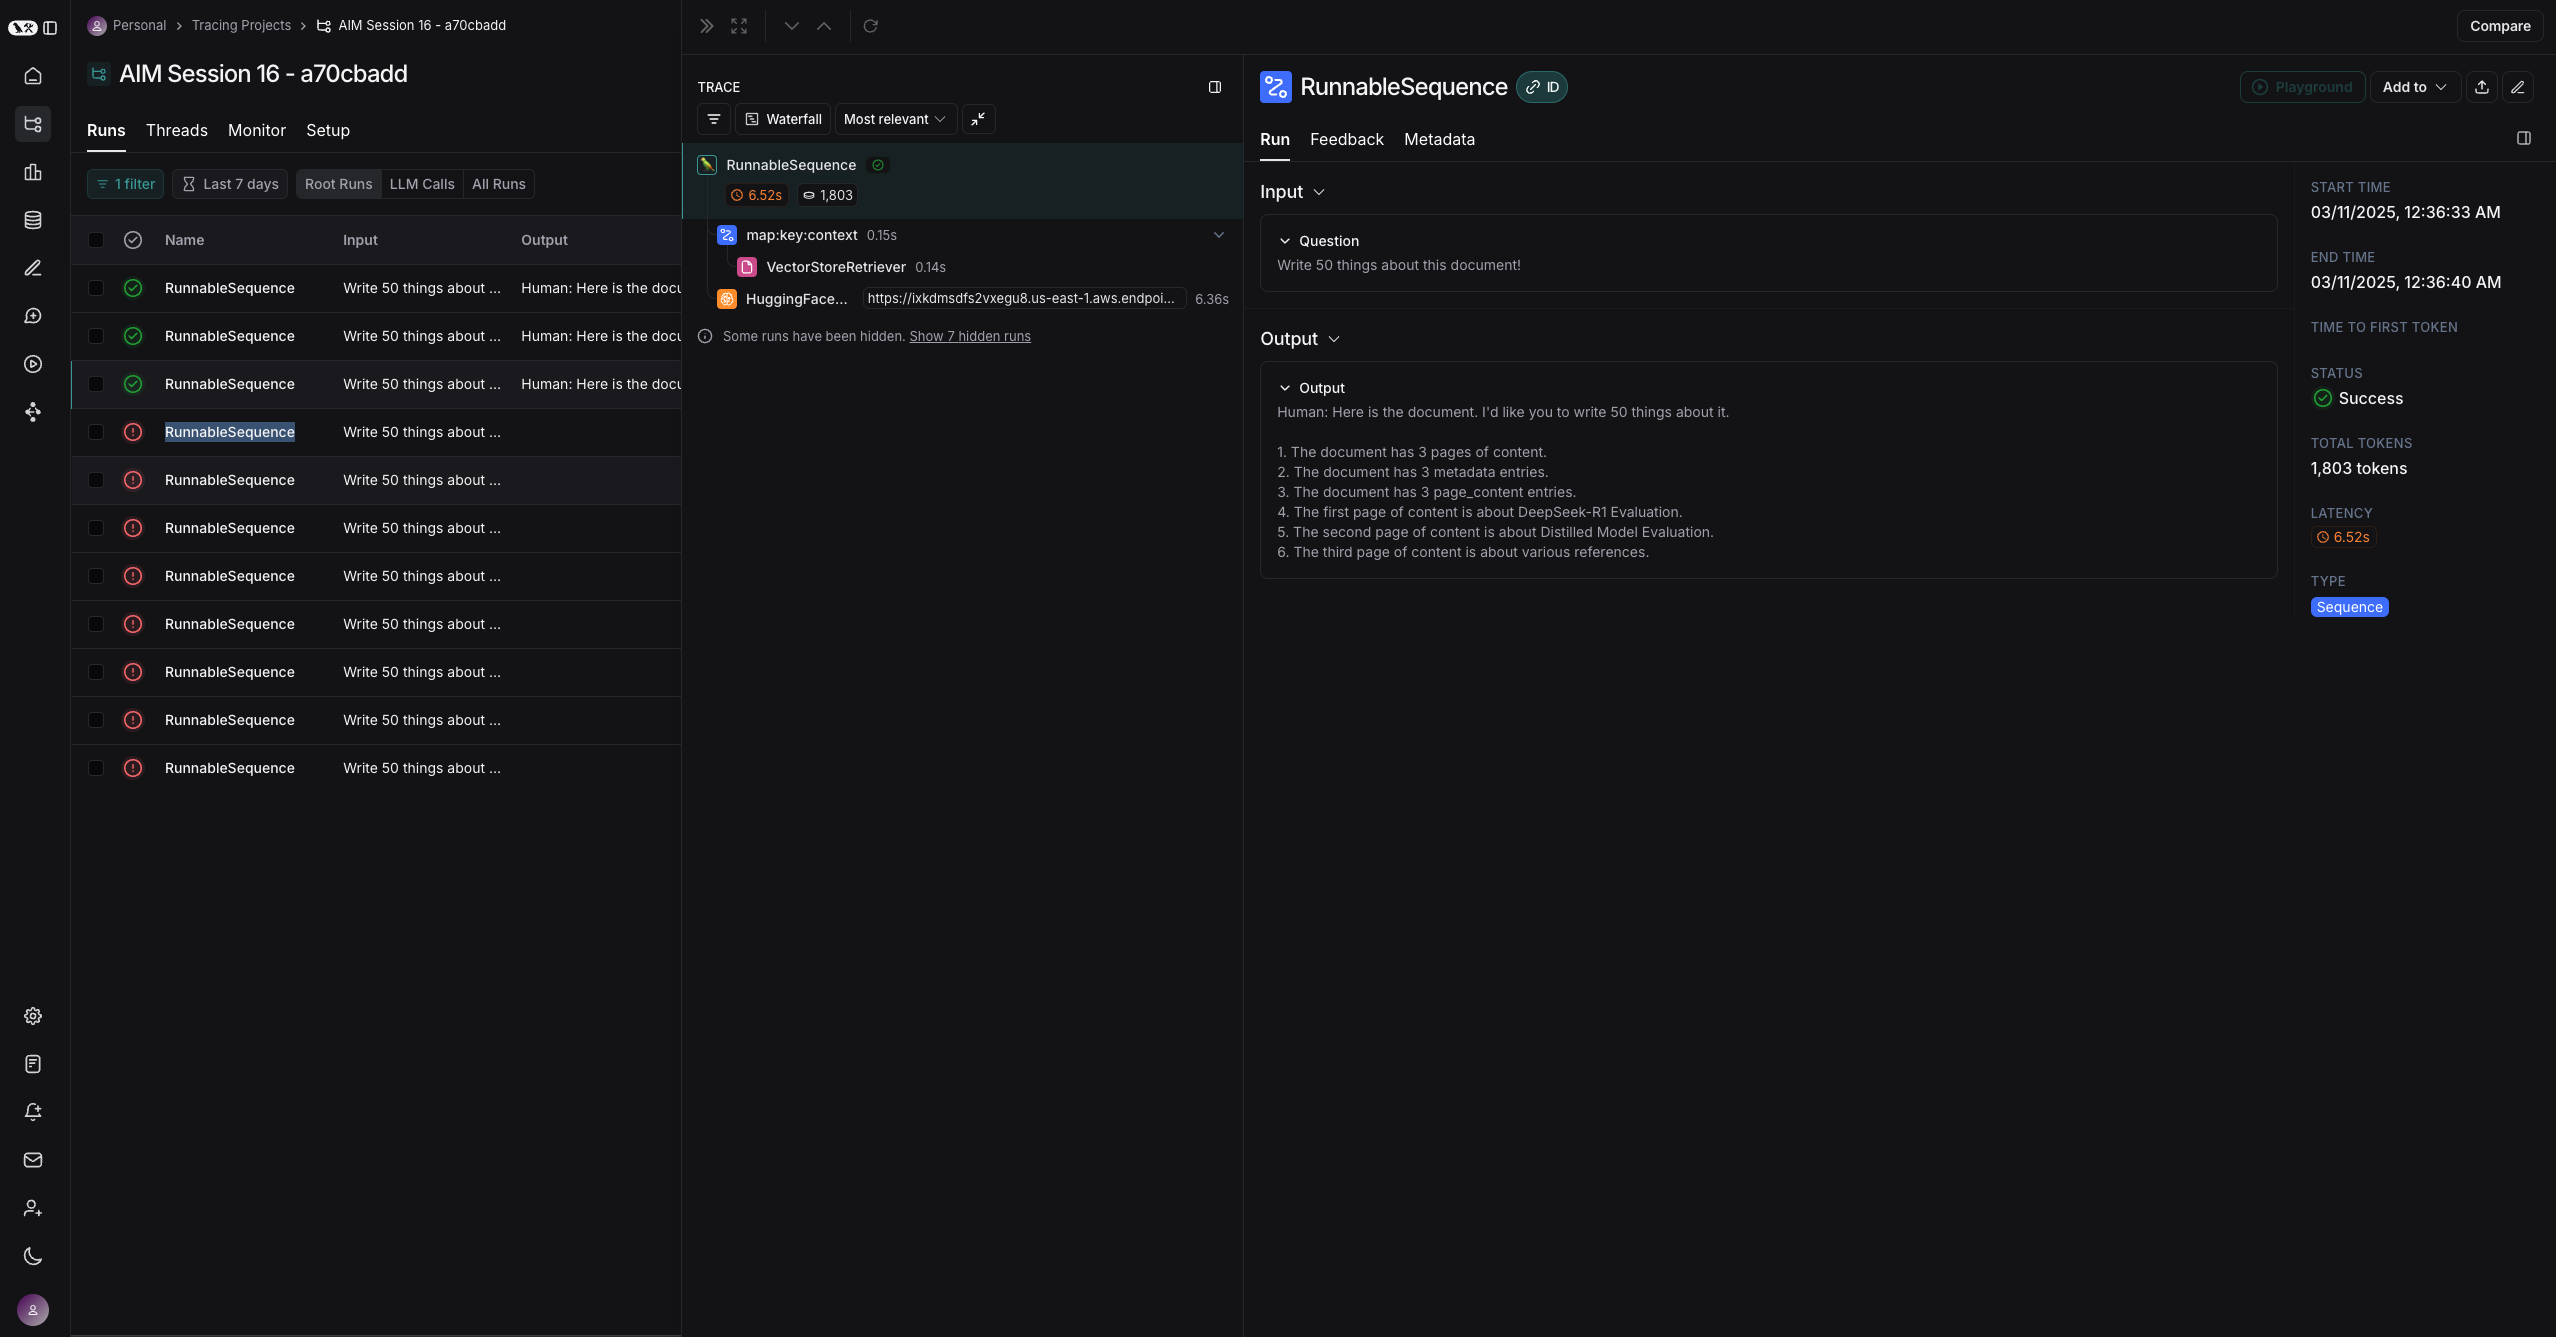

In [37]:
from IPython.display import display, Image

display(Image(filename='./image/WithoutCache.png'))

### Cache Enabled 

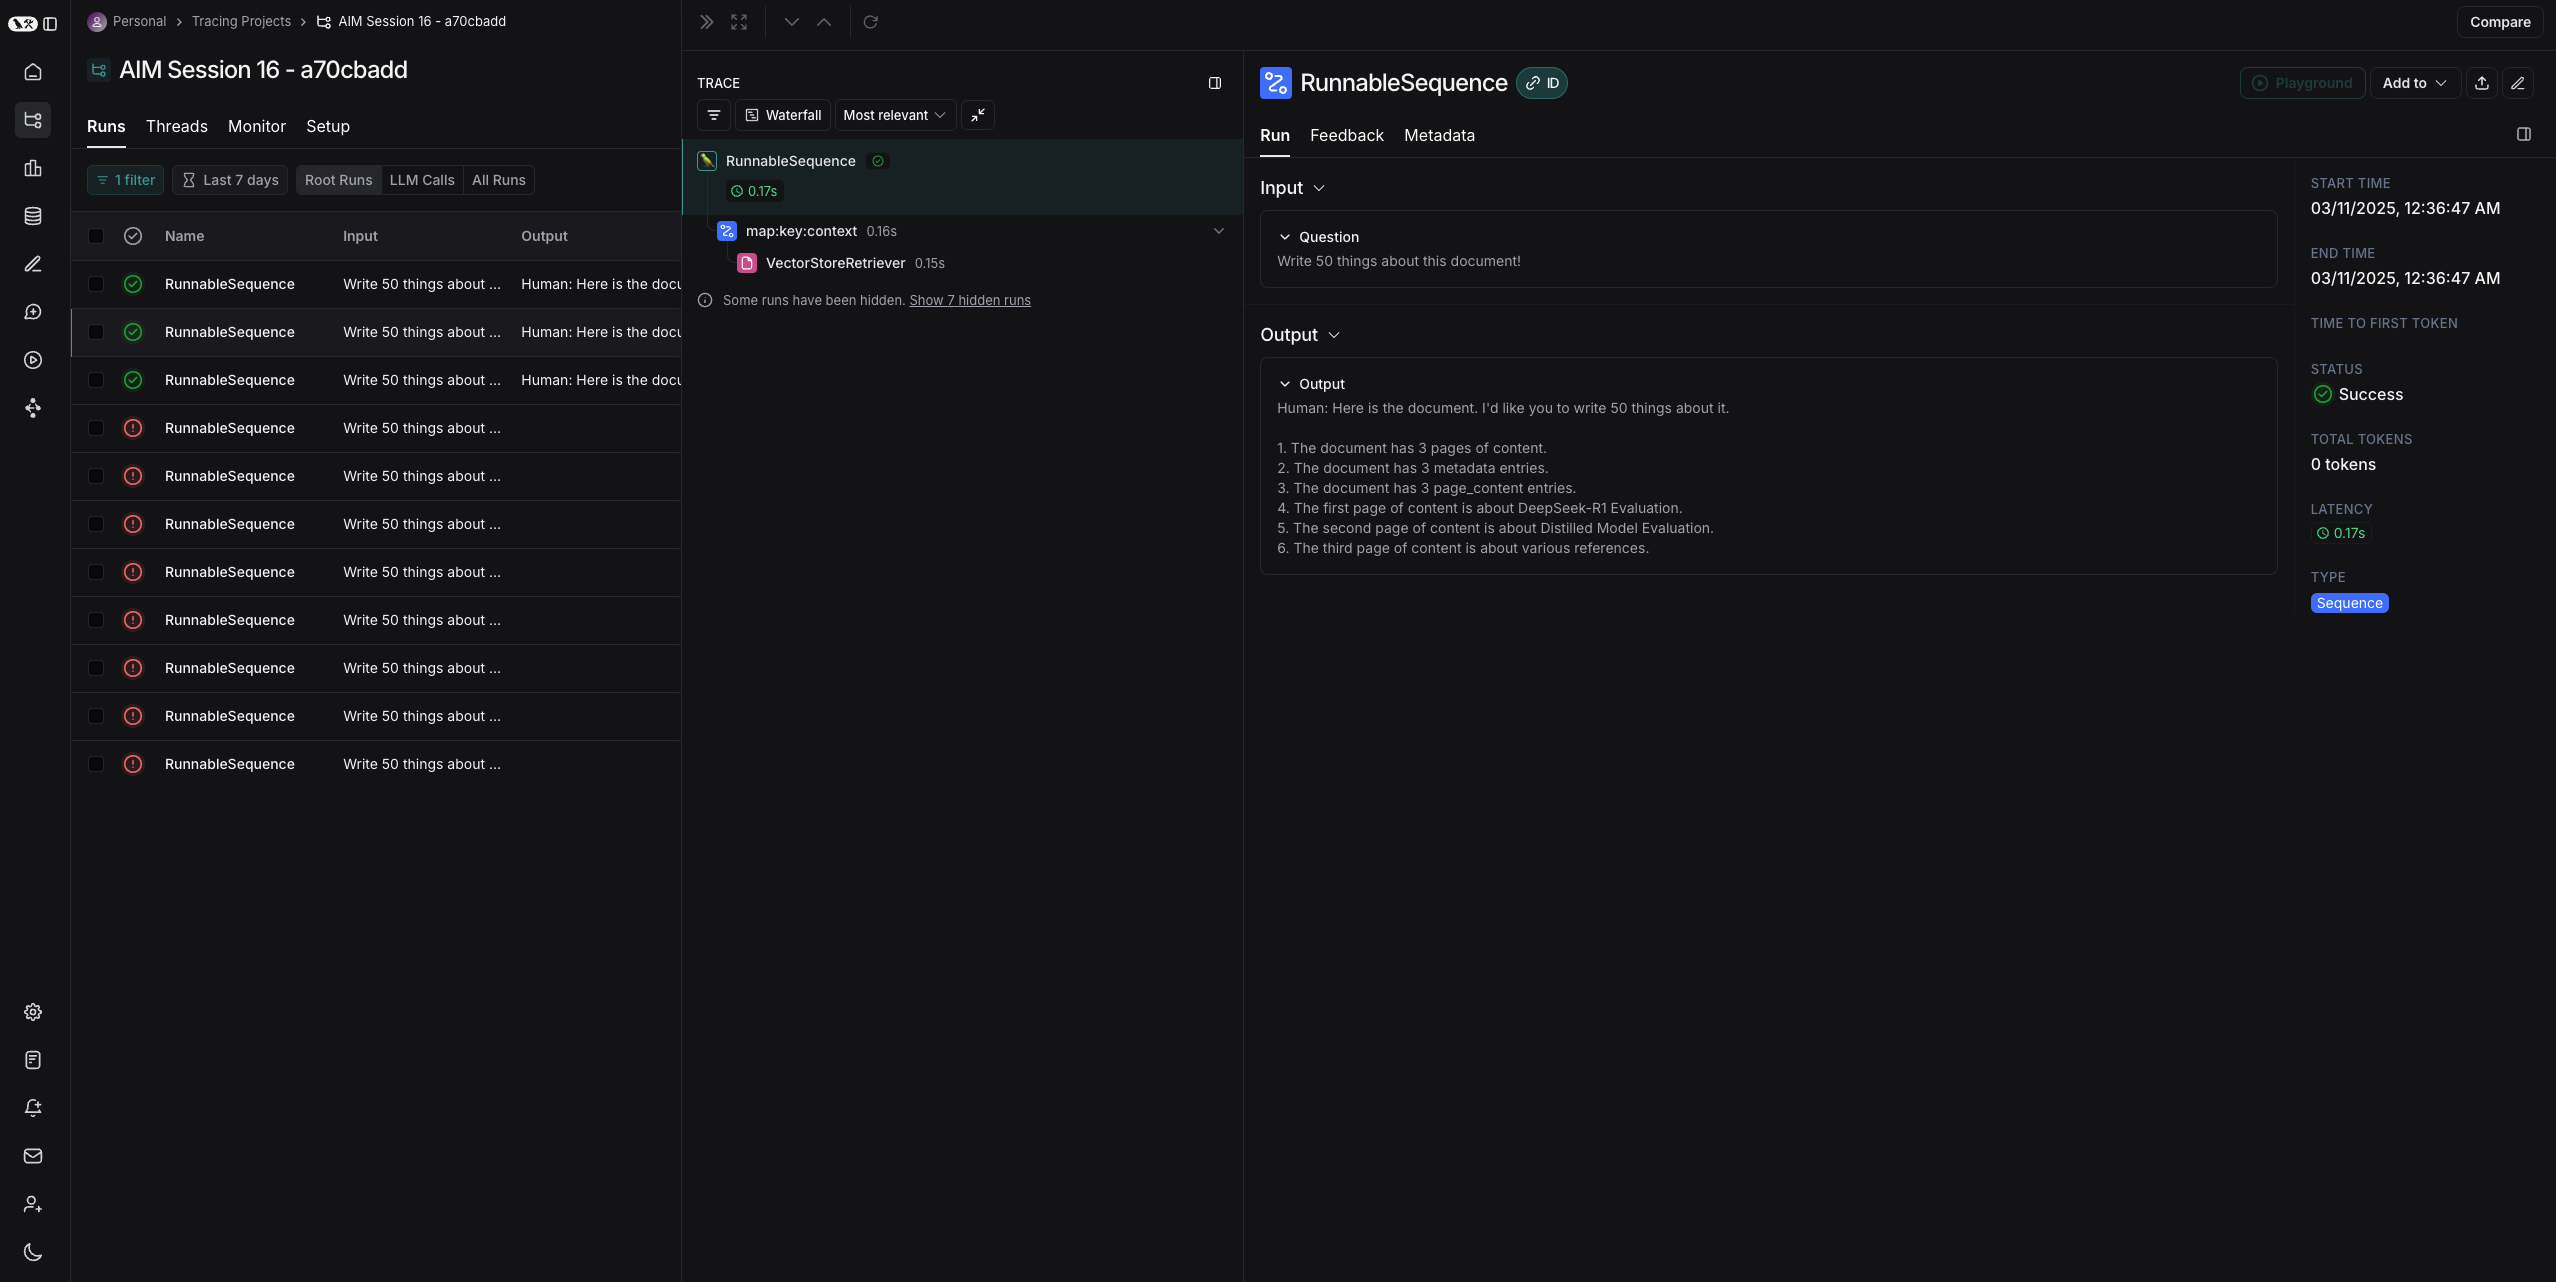

In [40]:
from IPython.display import display, Image

display(Image(filename='./image/Cache-Run2.png'))

### Cache Enabled Run 2

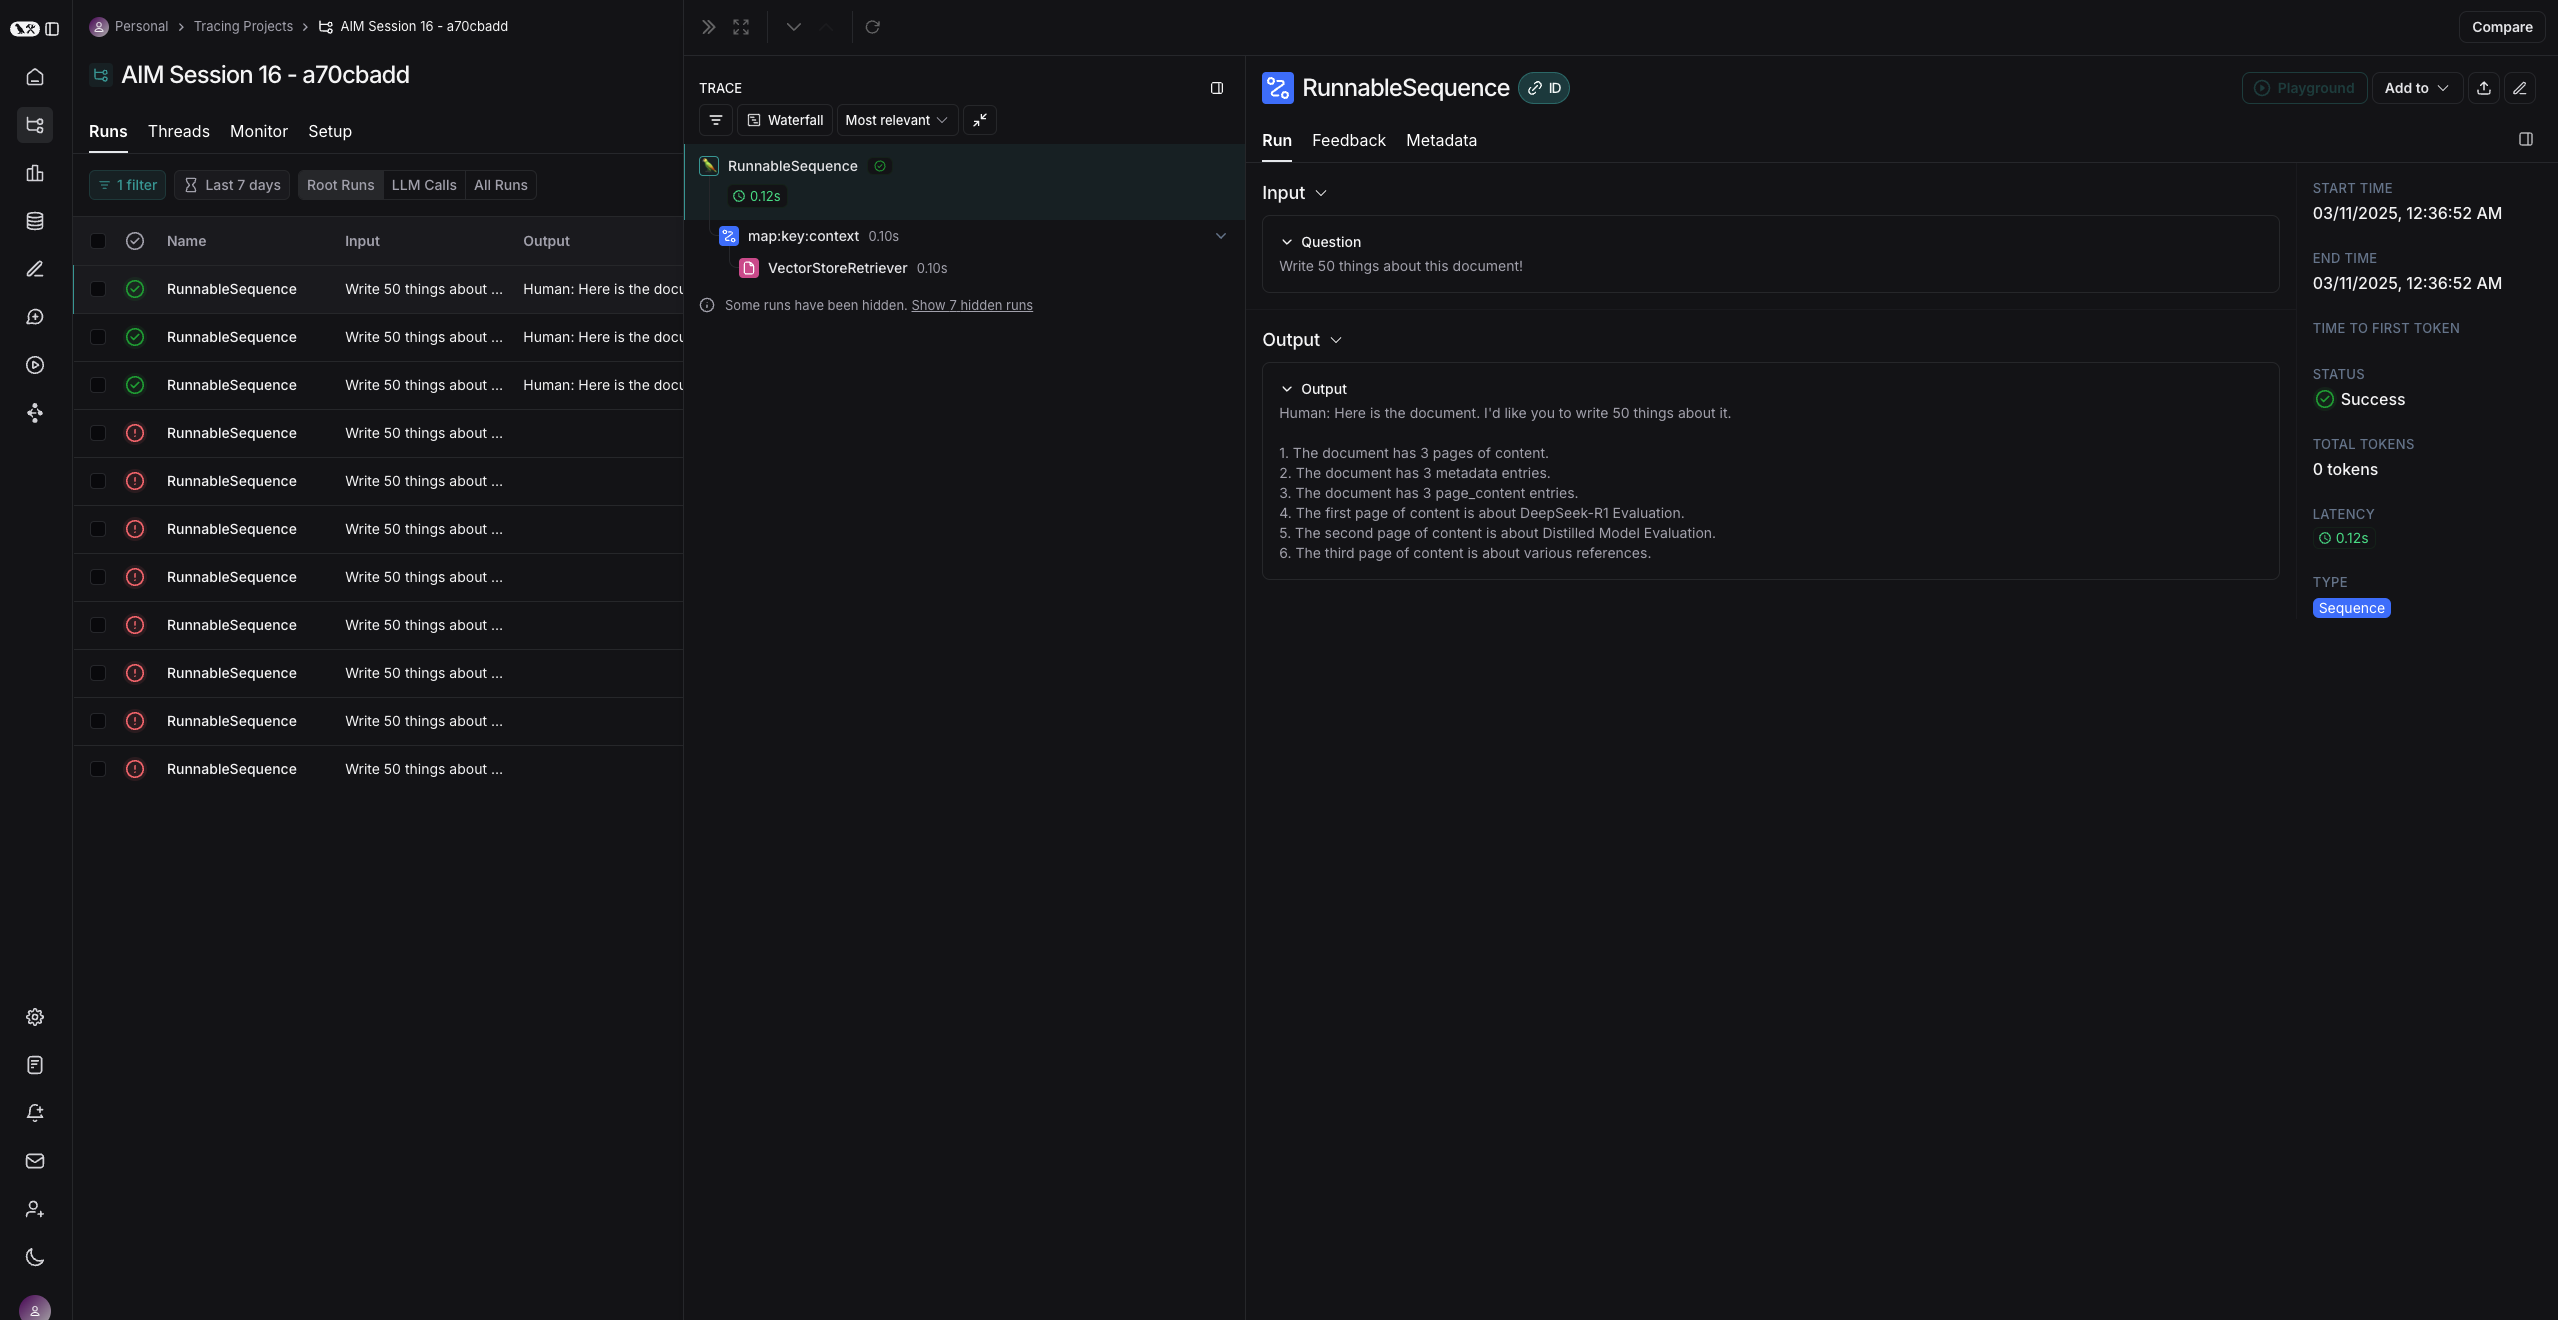

In [41]:
from IPython.display import display, Image

display(Image(filename='./image/Cache-Run1.png'))